외부변수

- 날씨
- 유동인구 => 지역
- 예측 => 예측 (실험해보기 좋을 수도) / 상관관계가 있으니 => pca 

오늘의 목표

- 개가되든밥이되드.... 결과???! score를 내자(민경님) 관수님 동의
- test / train => 제출 목표
- 내일 => 데이터 EDA
- 시간 : 5시반 default, 8시 => //////////1시반 ~ 2시 

- 8시 => 노트북


- 

In [27]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.parser import parse
from datetime import date, timedelta
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

In [2]:
air_reserve = pd.read_csv('air_reserve.csv').rename(columns={'air_store_id':'store_id'})
hpg_reserve = pd.read_csv('hpg_reserve.csv').rename(columns={'hpg_store_id':'store_id'})
air_store = pd.read_csv('air_store_info.csv').rename(columns={'air_store_id':'store_id'})
hpg_store = pd.read_csv('hpg_store_info.csv').rename(columns={'hpg_store_id':'store_id'})
air_visit = pd.read_csv('air_visit_data.csv').rename(columns={'air_store_id':'store_id'})
store_id_map = pd.read_csv('store_id_relation.csv').set_index('hpg_store_id',drop=False)
date_info = pd.read_csv('date_info.csv').rename(columns={'calendar_date': 'visit_date'}).drop('day_of_week',axis=1)
submission = pd.read_csv('sample_submission.csv')

In [3]:
date_info

,visit_date,holiday_flg
0,2016-01-01,1
1,2016-01-02,1
2,2016-01-03,1
3,2016-01-04,0
4,2016-01-05,0
...,...,...
512,2017-05-27,0
513,2017-05-28,0
514,2017-05-29,0
515,2017-05-30,0


In [4]:
submission['visit_date'] = submission['id'].str[-10:]
submission['store_id'] = submission['id'].str[:-11]
air_reserve['visit_date'] = air_reserve['visit_datetime'].str[:10]
air_reserve['reserve_date'] = air_reserve['reserve_datetime'].str[:10]
air_reserve['dow'] = pd.to_datetime(air_reserve['visit_date']).dt.dayofweek
hpg_reserve['visit_date'] = hpg_reserve['visit_datetime'].str[:10]
hpg_reserve['reserve_date'] = hpg_reserve['reserve_datetime'].str[:10]
hpg_reserve['dow'] = pd.to_datetime(hpg_reserve['visit_date']).dt.dayofweek
air_visit['id'] = air_visit['store_id'] + '_' + air_visit['visit_date']
hpg_reserve['store_id'] = hpg_reserve['store_id'].map(store_id_map['air_store_id']).fillna(hpg_reserve['store_id'])
hpg_store['store_id'] = hpg_store['store_id'].map(store_id_map['air_store_id']).fillna(hpg_store['store_id'])
hpg_store.rename(columns={'hpg_genre_name':'air_genre_name','hpg_area_name':'air_area_name'},inplace=True)
data = pd.concat([air_visit, submission]).copy()
data['dow'] = pd.to_datetime(data['visit_date']).dt.dayofweek
date_info['holiday_flg2'] = pd.to_datetime(date_info['visit_date']).dt.dayofweek
date_info['holiday_flg2'] = ((date_info['holiday_flg2']>4) | (date_info['holiday_flg']==1)).astype(int) #금토일월? 월요일도 포함된거에 대해 한번 살펴보면 좋을 듯

In [5]:
hpg_reserve.head()

,store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_date,reserve_date,dow
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1,2016-01-01,2016-01-01,4
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3,2016-01-01,2016-01-01,4
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2,2016-01-01,2016-01-01,4
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5,2016-01-01,2016-01-01,4
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13,2016-01-01,2016-01-01,4


In [6]:
hpg_store

,store_id,air_genre_name,air_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
...,...,...,...,...,...
4685,hpg_c6ed353a48c7c93e,Sichuan food,Tōkyō-to Chiyoda-ku None,35.695780,139.768453
4686,hpg_a58d2423360b2fb4,Sichuan food,Tōkyō-to Minato-ku Roppongi,35.666137,139.733978
4687,hpg_d2021704076cdd70,Shanghai food,Tōkyō-to Chiyoda-ku None,35.695780,139.768453
4688,hpg_602472570d65e219,Spain/Mediterranean cuisine,Tōkyō-to Toshima-ku None,35.730068,139.711742


In [7]:
hpg_reserve.nunique()

store_id            13325
visit_datetime       9847
reserve_datetime    11450
reserve_visitors       99
visit_date            517
reserve_date          478
dow                     7
dtype: int64

In [8]:
air_store['air_area_name0'] = air_store['air_area_name'].apply(lambda x: x.split(' ')[0])
lbl = LabelEncoder()
air_store['air_genre_name'] = lbl.fit_transform(air_store['air_genre_name'])
air_store['air_area_name0'] = lbl.fit_transform(air_store['air_area_name0'])

In [9]:
#data['visitors'] = np.log1p(data['visitors']) #로그를 씌운걸 넘 늦게 봣다
data = data.merge(air_store,on='store_id',how='left')
data = data.merge(date_info[['visit_date','holiday_flg','holiday_flg2']], on=['visit_date'],how='left')

In [10]:
hpg_data = hpg_reserve.merge(hpg_store, on = 'store_id', how = 'left')

In [11]:
hpg_data.head()

,store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_date,reserve_date,dow,air_genre_name,air_area_name,latitude,longitude
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1,2016-01-01,2016-01-01,4,NaN,NaN,NaN,NaN
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3,2016-01-01,2016-01-01,4,French,Hyōgo-ken Kōbe-shi None,34.692109,135.191698
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2,2016-01-01,2016-01-01,4,NaN,NaN,NaN,NaN
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5,2016-01-01,2016-01-01,4,NaN,NaN,NaN,NaN
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13,2016-01-01,2016-01-01,4,NaN,NaN,NaN,NaN


In [12]:
hpg_data.isnull().sum()

store_id                  0
visit_datetime            0
reserve_datetime          0
reserve_visitors          0
visit_date                0
reserve_date              0
dow                       0
air_genre_name      1129012
air_area_name       1129012
latitude            1129012
longitude           1129012
dtype: int64

In [13]:
hpg_data[hpg_data['air_genre_name'].isnull()]['store_id'].nunique() 
# 8635개에대한 레스토랑이 음식점 종류, 지역, 위도, 경도가 없는 것을 확인할 수 있음

8635

In [14]:
data.head()

,store_id,visit_date,visitors,id,dow,air_genre_name,air_area_name,latitude,longitude,air_area_name0,holiday_flg,holiday_flg2
0,air_ba937bf13d40fb24,2016-01-13,25,air_ba937bf13d40fb24_2016-01-13,2,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,0,0
1,air_ba937bf13d40fb24,2016-01-14,32,air_ba937bf13d40fb24_2016-01-14,3,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,0,0
2,air_ba937bf13d40fb24,2016-01-15,29,air_ba937bf13d40fb24_2016-01-15,4,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,0,0
3,air_ba937bf13d40fb24,2016-01-16,22,air_ba937bf13d40fb24_2016-01-16,5,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,0,1
4,air_ba937bf13d40fb24,2016-01-18,6,air_ba937bf13d40fb24_2016-01-18,0,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,0,0


holiday_fig1 : 일본의 공휴일
holiday_fig2 : 금토일월

In [18]:
train = data.iloc[:len(air_visit)]
test = data.iloc[len(air_visit):]

In [31]:
train.groupby(['visit_date'])['visitors'].sum().index

Index(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04', '2016-01-05',
       '2016-01-06', '2016-01-07', '2016-01-08', '2016-01-09', '2016-01-10',
       ...
       '2017-04-13', '2017-04-14', '2017-04-15', '2017-04-16', '2017-04-17',
       '2017-04-18', '2017-04-19', '2017-04-20', '2017-04-21', '2017-04-22'],
      dtype='object', name='visit_date', length=478)

<AxesSubplot:xlabel='visit_date'>

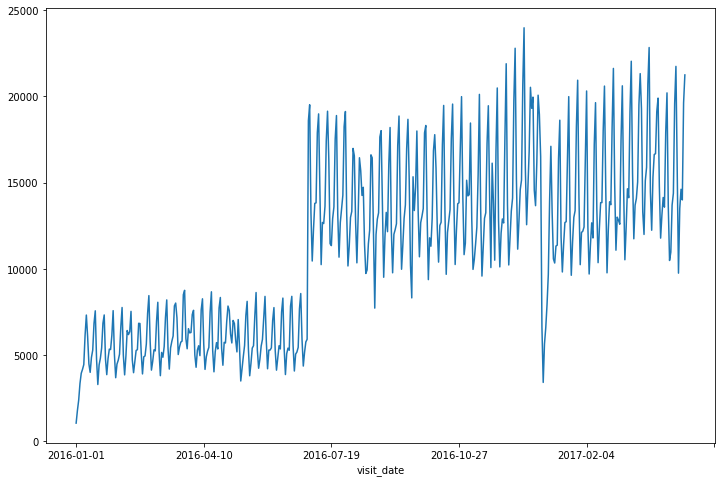

In [48]:
import matplotlib.dates as mdates
fig = plt.figure(figsize = (12, 8))
train.groupby(['visit_date'])['visitors'].sum().plot()

저 떄 왜 떨어졌을까 => 뭔가 패턴이 있을 것 같은데?

In [50]:
train.describe()

,visitors,dow,air_genre_name,latitude,longitude,air_area_name0,holiday_flg,holiday_flg2
count,252108.000000,252108.000000,252108.000000,252108.000000,252108.000000,252108.000000,252108.000000,252108.000000
mean,20.973761,3.019678,5.268123,35.613121,137.357865,5.086923,0.050673,0.314528
std,16.757007,1.923985,3.121573,2.044473,3.671577,2.875968,0.219329,0.464328
min,1.000000,0.000000,0.000000,33.211967,130.195555,0.000000,0.000000,0.000000
25%,9.000000,1.000000,2.000000,34.692337,135.341564,3.000000,0.000000,0.000000
50%,17.000000,3.000000,6.000000,35.658068,139.670038,7.000000,0.000000,0.000000
75%,29.000000,5.000000,7.000000,35.694003,139.751599,7.000000,0.000000,1.000000
max,877.000000,6.000000,13.000000,44.020632,144.273398,8.000000,1.000000,1.000000


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


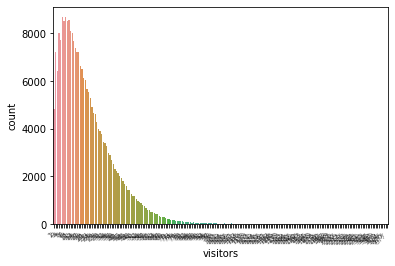

In [53]:
ax = sns.countplot('visitors', data = train)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45,
                  horizontalalignment='right',
                  fontweight='light',
                  fontsize='x-small'
                 )
plt.show()

In [19]:
hpg_store

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
...,...,...,...,...,...
4685,hpg_c6ed353a48c7c93e,Sichuan food,Tōkyō-to Chiyoda-ku None,35.695780,139.768453
4686,hpg_a58d2423360b2fb4,Sichuan food,Tōkyō-to Minato-ku Roppongi,35.666137,139.733978
4687,hpg_d2021704076cdd70,Shanghai food,Tōkyō-to Chiyoda-ku None,35.695780,139.768453
4688,hpg_602472570d65e219,Spain/Mediterranean cuisine,Tōkyō-to Toshima-ku None,35.730068,139.711742


In [21]:
hpg_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4690 entries, 0 to 4689
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   hpg_store_id    4690 non-null   object 
 1   hpg_genre_name  4690 non-null   object 
 2   hpg_area_name   4690 non-null   object 
 3   latitude        4690 non-null   float64
 4   longitude       4690 non-null   float64
dtypes: float64(2), object(3)
memory usage: 183.3+ KB


In [38]:
air_visit

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6
...,...,...,...
252103,air_24e8414b9b07decb,2017-04-18,6
252104,air_24e8414b9b07decb,2017-04-19,6
252105,air_24e8414b9b07decb,2017-04-20,7
252106,air_24e8414b9b07decb,2017-04-21,8


In [31]:
air_reserve[(air_reserve['air_store_id'] == 'air_877f79706adbfb06') & (air_reserve['reserve_datetime'].str == 'air_877f79706adbfb06')]

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
19,air_877f79706adbfb06,2016-01-02 18:00:00,2016-01-01 16:00:00,2
26,air_877f79706adbfb06,2016-01-02 21:00:00,2016-01-01 16:00:00,2
272,air_877f79706adbfb06,2016-01-08 21:00:00,2016-01-04 20:00:00,2
...,...,...,...,...
92126,air_877f79706adbfb06,2017-05-10 20:00:00,2017-04-12 23:00:00,6
92179,air_877f79706adbfb06,2017-05-12 21:00:00,2017-04-12 23:00:00,5
92295,air_877f79706adbfb06,2017-05-19 20:00:00,2017-03-31 22:00:00,9
92336,air_877f79706adbfb06,2017-05-25 20:00:00,2017-04-05 16:00:00,3


In [39]:
air_visit[air_visit['air_store_id'] == 'air_877f79706adbfb06']

,air_store_id,visit_date,visitors
74720,air_877f79706adbfb06,2016-01-01,3
74721,air_877f79706adbfb06,2016-01-02,12
74722,air_877f79706adbfb06,2016-01-08,17
74723,air_877f79706adbfb06,2016-01-09,8
74724,air_877f79706adbfb06,2016-01-12,15
...,...,...,...
75098,air_877f79706adbfb06,2017-04-18,12
75099,air_877f79706adbfb06,2017-04-19,11
75100,air_877f79706adbfb06,2017-04-20,17
75101,air_877f79706adbfb06,2017-04-21,14


In [25]:
air_visit['air_store_id'].nunique()

829

In [23]:
air_visit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252108 entries, 0 to 252107
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   air_store_id  252108 non-null  object
 1   visit_date    252108 non-null  object
 2   visitors      252108 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 5.8+ MB


In [24]:
store_id_map

,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7
...,...,...
145,air_b8925441167c3152,hpg_0cc0abae3a8b52de
146,air_f8233ad00755c35c,hpg_098e4dd30e54fee6
147,air_6607fe3671242ce3,hpg_1004356dc8ab69ec
148,air_ccd19a5bc5573ae5,hpg_df22bf146d2c7e19


In [26]:
date_info

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0
...,...,...,...
512,2017-05-27,Saturday,0
513,2017-05-28,Sunday,0
514,2017-05-29,Monday,0
515,2017-05-30,Tuesday,0
